<a href="https://colab.research.google.com/github/PeterVaneyghen/gcp/blob/main/Second_graded_assignment_training_16032023_1222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second graded assignment: convolutional neural networks

## 1. Imports, Drive mounting, helper function(s)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fix random seed for reproducibility
seed = 2023
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import Input
from tensorflow.keras.initializers import RandomNormal, Constant

2.11.0


In [2]:
# uncomment if you want to use Drive

# from google.colab import drive
# drive.mount('/content/gdrive')


!ls '/content/gdrive/My Drive/'

ls: cannot access '/content/gdrive/My Drive/': No such file or directory


In [3]:
#helper functions for visualisation

# same function as before - feel free to customize if you want!

def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['accuracy']),'g-', 
             label='Train accuracy')
    plt.plot(xvals, np.array(history.history['val_accuracy']),'r-',
             label = 'Validation accuracy')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()



## 2. Assignment overview

Since we have now definitely concluded that MNIST is too easy, we will move to a slightly more difficult data set to play with. It is called CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html) and contains (still TINY) natural images of objects in 20 different classes, each with 5 sub-classes (100 classes in total).

To make the problem slightly easier, we will only use the coarse differentiation into 20 classes.

The code below shows a simple example of a convolutional neural network. Your first task is to try and understand the layers and their parameters, using the Tensorflow-Keras documentation. Then start to optimise the network, using the same steps as in the first graded assignment: (i) find an unregularised network that is powerful enough to overfit on the training set (note that this task is harder, so you can tolerate slightly less fast-and-perfect learning as in the first graded assignment); (ii) regularise; (iii) iterate to improve. You can now also use the new things we discussed in the last lecture. Since the number of options is very large, try to take inspiration from what other people did (and mention your sources).

Note that augmentation dramatically slows down the learning process. For this reason, it is typically added after you already have a promising solution, i.e., a network that is tuned without augmentation, but for which you have good indications that more data would help. 

In order to pass for this assignment, you need to submit at least one properly tuned network, with a documentation of how you got there and a decent analysis of the performance of your network and the errors it still makes. The new components to be used in this assignment (compared to the first) are: **convolutional layers**, **batchnorm** and **augmentation**. To get really high grades, report on more than one approach, and/or try to reproduce something more advanced (from literature or online sources - mention your references), e.g., ResNet or DenseNet.

**It is not allowed to use pre-trained networks for this assignment!!**

The deadline is **Friday, March 17, 23:30**. 


In [4]:
# (X_train, Y_train), (X_test, Y_test) = cifar100.load_data(label_mode='coarse')
# # X_train.shape
# X_test.shape


## Loading the data

In the code below, we load the data. The option 'coarse' selects the 20-class version (instead of the 100-class version).

This code is mostly re-used from the first assignment. 

**Note:** Downloading the data takes a bit of time. You may want to consider saving it locally (or on Drive) as a numpy file to speed things up.

In [5]:
# Set this to False the first time to download data and store locally
# After switch to True again (local loading should be much faster)

LOCAL_LOAD = False

num_classes = 20

# Change path to wherever you need your files to be stored
DATA_PATH = './'


if LOCAL_LOAD:
    x_train_all = np.load(f'{DATA_PATH}CIFAR_Xtrain_all.npy')
    x_train = np.load(f'{DATA_PATH}CIFAR_Xtrain.npy')
    x_val = np.load(f'{DATA_PATH}CIFAR_Xval.npy')

    r_train_all_class = np.load(f'{DATA_PATH}CIFAR_rtrain_all_class.npy')
    r_train_class = np.load(f'{DATA_PATH}CIFAR_rtrain_class.npy')
    r_val_class = np.load(f'{DATA_PATH}CIFAR_rval_class.npy')
    
else:
    # Load the data: CIFAR100 with 20 class labels
    (x_train_all, r_train_all_class), ( _ , _ ) = cifar100.load_data(label_mode='coarse')

    # And do the same standardization as in the first assignment

    x_train_all = x_train_all.astype('float32')
    x_train_all /= 255.0
    
    
    # Split into train and validation set
    val_size = 6000
    x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, 
                                                                  test_size=val_size, random_state=0)
    
    

    np.save(f'{DATA_PATH}CIFAR_Xtrain_all',x_train_all)
    np.save(f'{DATA_PATH}CIFAR_Xtrain',x_train)
    np.save(f'{DATA_PATH}CIFAR_Xval',x_val)

    np.save(f'{DATA_PATH}CIFAR_rtrain_all_class',r_train_all_class)
    np.save(f'{DATA_PATH}CIFAR_rtrain_class',r_train_class)
    np.save(f'{DATA_PATH}CIFAR_rval_class',r_val_class)


# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = tf.keras.utils.to_categorical(r_train_all_class, num_classes)
r_train = tf.keras.utils.to_categorical(r_train_class, num_classes)
r_val = tf.keras.utils.to_categorical(r_val_class, num_classes)


# You can again use a subset of the training data for initial exploration
# In this case, 10000 samples is really too small, so we suggest 20000

# SUBSET = 20000
SUBSET = 44000

x_train_small = x_train[:SUBSET]
r_train_small = r_train[:SUBSET]


# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

N_train = x_train.shape[0]
N_val = x_val.shape[0]

print('x_train shape:', x_train.shape)
print('r_train shape:', r_train.shape)

print(N_train, 'train samples')
print('x_val shape:', x_val.shape)
print('r_val shape:', r_val.shape)

print(N_val, 'validation samples')



169001437/169001437 [==============================] - 2s 0us/step
x_train shape: (44000, 32, 32, 3)
r_train shape: (44000, 20)
44000 train samples
x_val shape: (6000, 32, 32, 3)
r_val shape: (6000, 20)
6000 validation samples


Note the shape of the training data. In the previous assignment, we had grayscale images, consisting of 28x28 pixels. As we were using Dense networks then, we flattened the pixels into a single vector per image. We will now be using convolutional networks, which means we need to keep all pixel values in 2D arrays.

In addition, in the current assignment, the data consists of **colour** images, which means that each image consists of 3 arrays or *channels* (RGB: red, green, blue). So every sample is now a tensor of 32x32x3 numbers. 

It is a general agreement that the **first** dimension of the training data always reflects the number of samples (in a batch or in the whole set). All other dimensions are the sample dimensions, with the **last** dimension being the number of channels (note: this is called *channels_last*, which is the default setting in Tensorflow). Hence, our complete training set is a tensor of shape (44000, 32, 32, 3). When training with batches, each batch will be a tensor of shape (batch_size, 32, 32, 3). Since models can be trained with different batch sizes, the first dimension will be 'None' in your model summary: this is a placeholder that is only filled in when actually training the model.

## Looking at the data

The images are very low resolution, to the extent where it is often hard even for humans to recognise what is on them. Considering that there are less training samples than in the first assignment, that there are twice as many classes and the data is more complex, it is clear that this task is a lot more difficult. Below are a few examples of the training data:

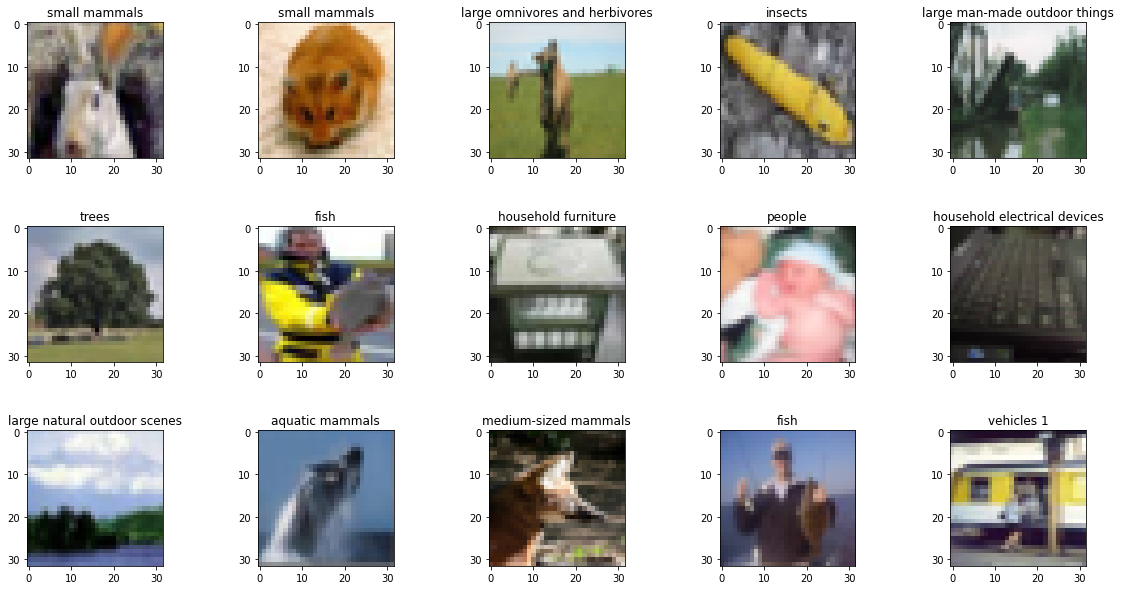

In [6]:
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title(labels[int(r_train_class[idx,0])])
    plt.imshow(x_train[idx],  interpolation='None')

In [7]:
#  ?Conv2D()

# The functional API: an initial model to show how it's done

As explained during the lecture, we will now use Tensorflow's **functional API** instead of the very simple **sequential API** because that allows the construction of more complex structures such as residual connections.

The code below shows a simple example of a convolutional neural network.

As in the previous assignment this model only demonstrates the mechanics. It should not be used as an example of good settings, neither for the architecture nor for any of the hyperparameters. Note also that no regularisation has been introduced yet (you should know how to do this from the first graded assignment)! In addition to dropout, L1 and L2, you can now also use maxnorm. 

Batchnormalisation is also not introduced yet. Although it was mentioned in the lecture that this also adds a bit of regularisation, its  main purpose is to improve learning convergence. For this reason, we advise to start using this from the start in the first stage (desiging a powerful unregularised network).

If you use batchnorm, it is generally advised to put it **before** the activation (cf. lecture), i.e., between the convolution and the ReLu (or other) nonlinearity. This is not possible if you specify the nonlinearity as a parameter of the conv layer. We have therefore split it off as a separate layer in the code below.
Dropout is typically applied on the inputs of the layer you want to regularise, i.e., **after** the nonlinearity of the previous layer. Typically, the more parameters a layer has, the more dropout you will be able to use on its inputs.

Recall the two main structural parameters of a network: 
- layer width (for each layer): determines how many "different things" (features) can be extracted by a layer
- network depth (how many layers): determines the non-linear complexity of the features that can be extracted

In convnets, layers are often organised in blocks of layers with the same width, followed by a pooling step to reduce the layer size. You can use blocks of one or more layers. In the example below, there are two blocks and two layers per block. As advised during the lecture, we stick to powers of two for everything and the number of channels per layer is doubled after each pooling step. This way spatial features (things you see on the image) are gradually translated into abstract features (concepts that are useful to make the classification).

Padding (same) is used here for all conv layers. This is quite standard and avoids you having to keep track of channel shapes (input and output channels of conv layers are equal if padding is used).

After the last conv layer block, you need to reshape all the remaining features into a single vector again, such that they can be input into the Dense layer(s). This is what the 'Flatten()' layer does - an alternative is to combine the last pooling layer and the Flatten layer into a global pooling layer, which retains only one feature per channel (Max or Average, see docs for more info).


In [8]:
# def initial_model(num_classes = 20):
    
#     # tell the model which input shape the samples will have
#     inputs = Input((32, 32, 3), dtype=tf.float32)
    
#     # first conv block, width = 16
#     x = Conv2D(128, (3, 3), padding='same')(inputs)  # first layer operates on inputs
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       # split up linear layer and activation to allow for batchnorm
#     x = Conv2D(128, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     # x = Dropout(0.1)(x)

#     #  second conv block, width = 32
#     x = Conv2D(128, (3, 3), padding='same')(x)  
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = Conv2D(128, (3, 3), padding='same')(x)
#     x = BatchNormalization() (x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     # x = Dropout(0.3)(x)

#     #  third conv block, width = 64
#     x = Conv2D(256, (3, 3), padding='same')(x)  
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = Conv2D(256, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     # x = Dropout(0.5)(x)

#     #  fourth conv block, width = 128
#     x = Conv2D(512, (3, 3), padding='same')(x)  
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = Conv2D(512, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     # x = Dropout(0.65)(x)

#     #  fifth conv block, width = 256
#     x = Conv2D(1024, (3, 3), padding='same')(x)  
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = Conv2D(1024, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x) # batch normalization
#     x = Activation('relu')(x)                       
#     x = MaxPooling2D(pool_size=(2, 2))(x) # Architecture 2
#     x = Dropout(0.5)(x)
    
#     # x = Dropout(0.65)(x)
#     # end of convolutional layers: convert remaining features to vector as input for Dense output stack
#     # x = Flatten()(x)

#     # #  sixth conv block, width = 512
#     # x = Conv2D(512, (3, 3), padding='same')(x)  
#     # x = BatchNormalization()(x) # batch normalization
#     # x = Activation('relu')(x)                       
#     # x = Conv2D(512, (3, 3), padding='same')(x)
#     # x = BatchNormalization()(x) # batch normalization
#     # x = Activation('relu')(x) 
    
#     # x = Dropout(0.1)(x) # Architecture 2
#     # end of convolutional layers: Global average pooling
#     # x = GlobalAveragePooling2D()(x)
#     # x = Dropout(0.1)(x)

#     # one hidden dense layer to show you how
#     # as said during lecture: with a well-designed conv network, this may not be necessary!
#     # x = Dense(512)(x)
#     # x = BatchNormalization()(x) # batch normalization
#     # x = Activation('relu')(x)
#     # x = Dropout(0.1)(x)
    
#     x = Flatten()(x)
#     # x = Dense(512)(x)
#     # x = Activation('relu')(x)
#     # x = Dropout(0.2)(x)
#     # x = BatchNormalization()(x)
#     # x = BatchNormalization(momentum=0.95, 
#             # epsilon=0.005,
#             # beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
#             # gamma_initializer=Constant(value=0.9))(x)
    
#     # and finally the linear classification outpur layer
#     output = Dense(num_classes, activation="softmax")(x)
#     model = tf.keras.Model(inputs=inputs, outputs=output)

#     # Note that, in contrast to the first graded assignment, 
#     # we have taken the model compilation out of this function (it is done in the model training block)
    
#     return model

In [9]:
# def initial_model(num_classes = 20):
#   # tell the model which input shape the samples will have
#   inputs = Input((32, 32, 3), dtype=tf.float32)
    
#   # first conv block, width = 128
#   x = Conv2D(128, (3, 3), padding='same', kernel_constraint=max_norm(1))(inputs)  # first layer operates on inputs
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       # split up linear layer and activation to allow for batchnorm
#   x = Conv2D(128, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = MaxPooling2D(pool_size=(2, 2))(x)
#   x = Dropout(0.2)(x)

#   #  second conv block, width = 128
#   x = Conv2D(128, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)  
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = Conv2D(128, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)
#   x = BatchNormalization() (x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = MaxPooling2D(pool_size=(2, 2))(x)
#   x = Dropout(0.2)(x)

#   #  third conv block, width = 256
#   x = Conv2D(256, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)  
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = Conv2D(256, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = MaxPooling2D(pool_size=(2, 2))(x)
#   x = Dropout(0.2)(x)

#   #  fourth conv block, width = 512
#   x = Conv2D(512, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)  
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = Conv2D(512, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = MaxPooling2D(pool_size=(2, 2))(x)
#   x = Dropout(0.2)(x)

#   #  fifth conv block, width = 1024
#   x = Conv2D(1024, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)  
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = Conv2D(1024, (3, 3), padding='same', kernel_constraint=max_norm(1))(x)
#   x = BatchNormalization()(x) # batch normalization
#   x = Activation('relu')(x)                       
#   x = MaxPooling2D(pool_size=(2, 2))(x) # Architecture 2
#   x = Dropout(0.2)(x)

#   x = Flatten()(x)
#   # x = Dense(1024)(x)
#   # x = Activation('relu')(x)
#   # x = Dropout(0.2)(x)
#   # x = BatchNormalization(momentum=0.95,
#   #                        epsilon=0.005,
#   #                        beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
#   #                        gamma_initializer=Constant(value=0.9))(x)
  
#   output = Dense(num_classes, activation="softmax")(x)
#   model = tf.keras.Model(inputs=inputs, outputs=output)

#   return model

In [10]:
def initial_model(num_classes = 20):
  # tell the model which input shape the samples will have
  inputs = Input((32, 32, 3), dtype=tf.float32)
    
  # first conv block, width = 128
  x = Conv2D(128, (3, 3), padding='same')(inputs)  # first layer operates on inputs
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       # split up linear layer and activation to allow for batchnorm
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)

  #  second conv block, width = 128
  x = Conv2D(128, (3, 3), padding='same')(x)  
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization() (x) # batch normalization
  x = Activation('relu')(x)                       
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.5)(x)

  #  third conv block, width = 256
  x = Conv2D(256, (3, 3), padding='same')(x)  
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.5)(x)

  #  fourth conv block, width = 512
  x = Conv2D(512, (3, 3), padding='same')(x)  
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  x = Conv2D(512, (3, 3), padding='same')(x)
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.5)(x)

  #  fifth conv block, width = 1024
  x = Conv2D(1024, (3, 3), padding='same')(x)  
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  x = Conv2D(1024, (3, 3), padding='same')(x)
  x = BatchNormalization()(x) # batch normalization
  x = Activation('relu')(x)                       
  # x = MaxPooling2D(pool_size=(2, 2))(x) # Architecture 2
  x = Dropout(0.5)(x)

  # #  sixth conv block, width = 1024
  # x = Conv2D(2048, (3, 3), padding='same')(x)  
  # x = BatchNormalization()(x) # batch normalization
  # x = Activation('relu')(x)                       
  # x = Conv2D(2048, (3, 3), padding='same')(x)
  # x = BatchNormalization()(x) # batch normalization
  # x = Activation('relu')(x)                       
  # # x = MaxPooling2D(pool_size=(2, 2))(x) # Architecture 2
  # # x = Dropout(0.2)(x)

  x = GlobalAveragePooling2D()(x)

  # x = Flatten()(x)
  # x = Dense(1024)(x)
  # x = Activation('relu')(x)
  # x = Dropout(0.2)(x)
  # x = BatchNormalization(momentum=0.95,
  #                        epsilon=0.005,
  #                        beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
  #                        gamma_initializer=Constant(value=0.9))(x)
  
  output = Dense(num_classes, activation="softmax")(x)
  model = tf.keras.Model(inputs=inputs, outputs=output)

  return model

In [12]:
batch_size = 64
# batch_size = 512
batches_per_epoch = int(N_train/batch_size) 
epochs = 60
LR = 0.001
# LR = 0.0005
stopping_patience = 10
stopping_delta = 0.0001

model_1 = initial_model()
model_1.summary()

model_1.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=LR), 
                metrics=['accuracy'])

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)

history_1 = model_1.fit(x_train, r_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,  
                        validation_data=(x_val, r_val),
                        callbacks = [stopping_callback],
                        shuffle=True)

model_savepath = "mymodel_v1"  
model_1.save(model_savepath)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                          

Training set Accuracy: 0.9487
Training set Loss:0.172348

Validation set Accuracy: 0.7267
Validation set Loss:0.974357



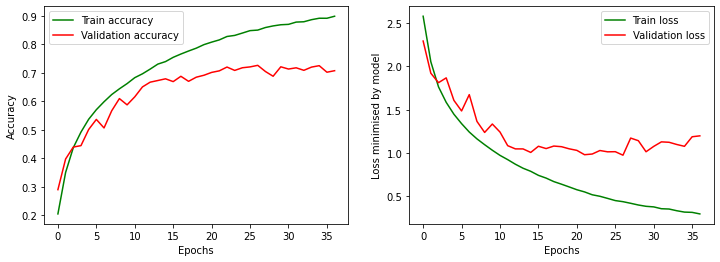

In [13]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

We can see that, besides the fact that learning convergence has not been properly tuned, it is not sufficiently powerful and heavily overfitting!

One thing to note is that there are a **huge** number of parameters in the first Dense layer!! This is not surprising, since it has > 2000 input features. Conv layers have far fewer features. The ideal way to avoid the explosion of parameters in the first Dense layer is therefore to take conv layers + pooling much further, such that the number of features per channel gets down to 2x2 or even 1x1 before calling flatten(). As stated before, you can also shortcut a few levels by using global pooling.

Use dropout mainly in (large) dense layers, i.e., the dense layers with most weights. Be careful with dropout in the output layer since that normally does not have too many weights. Whether or not it's useful to add dropout on conv layers again depends on the number of parameters they have. Adding too much dropout anywhere will generally make results worse. Introducing dropout in dense and conv layers at the same time is not advised: it may lead you to the wrong conclusions, since they may have opposite effects. As always: change one thing at the time in order to be able to draw clear conclusions.

As you make your network deeper (which you definitely should), you will increasingly run into 'vanishing gradients' (not the 'decreasing derivatives' part but the 'decreasing precision' part). If you have vanishing gradients, gradient descent will not allow you to fully exploit the power of your model. The first step of "making your network powerful enough" will therefore not succeed as well as you would hope!

One of the first things you should do if you want to make deeper networks is therefore counteract vanishing gradients by introducing batchnormalisation (or later: adding skip-connections, see, e.g., https://github.com/pravinkr/resnet50-cifar10-keras/blob/master/cifar_10_with_resnet_keras.ipynb - note that this requires some more advanced coding!). You can introduce batchnormalisation after each layer. Since batchnorm also acts as a regulariser (see theory), you may also see a decrease in overfitting. A final hint: batchnorm tends to combine well with maxnorm (and dropout, obviously).

In practice, batchnorm is often introduced from the beginning, i.e. in the stage of "making your network powerful enough", since it is often the only way to properly explore the power of deeper networks.

The steps you should take to tune your network are similar to the first assignment. However, since the number of options has increased dramatically, it is a good idea to have a look at literature or online examples first. You won't find many results on the 'coarse' version of CIFAR100, but you can use networks used on the same data (with the full 100 classes) or even networks used on the simpler CIFAR10 (similar data, but only 10 classes) as inspiration.



## 3. Augmentation

When using data augmentation on large data sets, it is not feasible to generate the augmented samples up-front. Instead, they are generated 'on the fly' when reading in batches: before each training sample is used in a batch, it is first augmented, so each time the same original sample is used, its augmented version is different. This is done using an ImageDataGenerator.

Before actually using augmentation, it is usually a good idea to have a look at some augmented images. The code block below shows how you can do this.

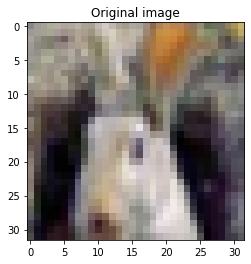

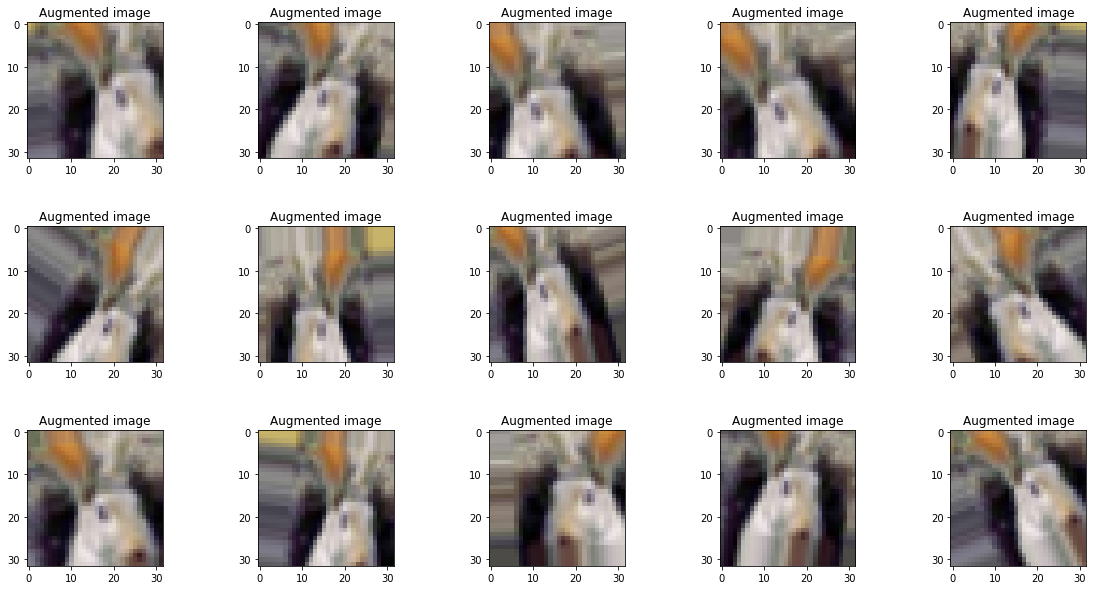

In [14]:
# An object from the class ImageDataGenerator will do 'on-the-fly' data augmentation
# every time you call its function .flow()

# Note that not all options are used here: check the docs for additional info
# the class also contains a 'hook' for adding your own augmentation functions

datagen = ImageDataGenerator(
        rotation_range=30.0,  # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode = 'nearest', # what to do with 'new' pixels that occur as the result of a transformation
        zoom_range = 0.2)  

# select and show an image from the training set
img_index = 0

plt.figure()
plt.imshow(x_train[img_index],  interpolation='None')
plt.title("Original image")
plt.show()

testit = datagen.flow(x_train[img_index:img_index+1], batch_size=1)

# generate 15 augmented images (the first one is the original image)
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Augmented image")
    plt.imshow(testit.next()[0,:,:,:],  interpolation='None')
plt.show()



Use the code above to decide how much augmentation you can allow while still getting 'realistic' images, i.e., images you would want your network to be able to classify. Remember that adding more extreme augmentation makes your task harder, while using too little augmentation will barely have an effect and only slow down your training. Try to aim for the point where you see that augmented images look sufficiently different but still realistic.

**Large data sets (advanced):**
The data set in this assignment is small enough to fit in memory so we can use the example code provided here. For realistic image data sets, this is usually not the case. This is also solved by using an ImageDataGenerator object, but now using the iterator 'flow_from_directory()'. In that case, batches are made by reading each sample from disk and transforming it as needed (preprocessing and/or augmentation). Now, only your batch needs to fit in memory (and your network, of course). This is explained in [this tf Keras example notebook](https://www.tensorflow.org/tutorials/images/classification). Note that this implies that the rescaling we did at the beginning of this notebook will also be done by the ImageDataGenerator class. You would need to make two such classes: one for training (with augmentation, if you want that) and one for validation (without augmentation), since they would now read from different paths.  

**Using augmentation in model training**:
In the code block below, you can see how you can compile and train the same model with data augmentation. It also includes early stopping. 

You wil notice that training now takes longer because of the image preprocessing (augmentation) that is required!

For this reason it is advisable to first tune your network without augmentation. You want to get into a regime where you are still overfitting and you have a clear indication that more data would help, for example by comparing training and validation scores for two training set sizes (i.e., two points of a learning curve), or when you find that considerable overfitting remains, but adding any other type of regularisation makes validation performance worse. 

Then, check which types and levels of augmentation actually help by switching back to the small data set (comparing train and validation scores for unaugmented training and augmented training, where everything else is kept constant). Since this is rough exploration, you can also save time by setting your patience values a bit lower. Once you think you have good augmentation settings, switch back to the larger training set an do a full-blown training run.

**Warning** running the code below takes considerably longer!!


In [18]:
batch_size = 64
batches_per_epoch = int(N_train/batch_size) 
epochs = 100
LR = 0.001
stopping_patience = 10
stopping_delta = 0.0001

au_model_1 = initial_model()
au_model_1.summary()

au_model_1.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=LR), 
                metrics=['accuracy'])

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)

datagen = ImageDataGenerator(
        rotation_range=30.0,  # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode = 'nearest', # what to do with 'new' pixels that occur as the result of a transformation
        zoom_range = 0.2)  

# Compute quantities required for some augmentation functions
# (e.g., std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train, augment=True)

# Now the data generator takes care of creating augmented batches "on the fly"
au_history_1 = au_model_1.fit(datagen.flow(x_train, r_train, batch_size=batch_size),
                        epochs=epochs,
                        verbose=1,  
                        validation_data=(x_val, r_val),
                        callbacks = [stopping_callback],
                        shuffle=True)

au_model_savepath = "mymodel_v1_augmented"  
au_model_1.save(au_model_savepath)



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_30 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                          

In [19]:
[au_train_loss, au_train_accuracy] = au_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(au_train_accuracy))
print("Training set Loss:{:7.6f}\n".format(au_train_loss))

[au_val_loss, au_val_accuracy] = au_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(au_val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(au_val_loss))



Training set Accuracy: 0.8224
Training set Loss:0.540148

Validation set Accuracy: 0.7382
Validation set Loss:0.856038



By running the code below, you can compare the situation with and without augmentation (or any two situations ...). Note that, when comparing across models with different batch sizes, it is more informative to plot weight update steps than epochs (based on GA1 code).

**Something to think about:** For the curves of the second training run (with augmentation), why is is the curve for the train accuracy lower than that for validation accuracy?? (check lecture recording if you don't know the answer)

In this case, we can conclude that augmentation managed to reduced most of the overfitting, but it did not fundamentally improve validation accuracy. The main reason for this is probably that the network is nowhere close to decent yet: remember that **augmentation can help reduce overfitting**. However, this can only improve validation accuracy if the model has low enough bias. In this case, bias is still way too high!

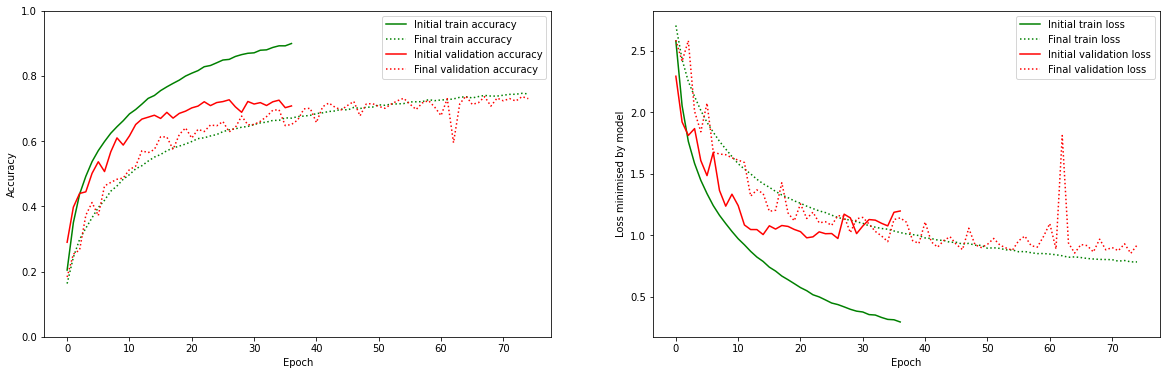

In [20]:
def plot_dual_history(before,after):
  plt.figure(figsize = (20,6))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(before.epoch, np.array(before.history['accuracy']),'g-',
           label='Initial train accuracy')
  plt.plot(after.epoch, np.array(after.history['accuracy']),'g:',
           label='Final train accuracy')
  plt.plot(before.epoch, np.array(before.history['val_accuracy']),'r-',
           label = 'Initial validation accuracy')
  plt.plot(after.epoch, np.array(after.history['val_accuracy']),'r:',
           label = 'Final validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(before.epoch, np.array(before.history['loss']),'g-',
           label='Initial train loss')
  plt.plot(after.epoch, np.array(after.history['loss']),'g:',
           label='Final train loss')
  plt.plot(before.epoch, np.array(before.history['val_loss']),'r-',
           label = 'Initial validation loss')
  plt.plot(after.epoch, np.array(after.history['val_loss']),'r:',
           label = 'Final validation loss')
  plt.legend()


plot_dual_history(history_1,au_history_1)


In [23]:
au_model_savepath = "mymodel_v1_augmented"  
au_model_1.save(au_model_savepath)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Now it's your turn again
Make a new notebook in which you use the code examples in this notebook to train your own network. Obviously, you are allowed to add code of your own.
Please make sure that the final model notebooks you hand in **only contain necessary code and explanation blocks** and only **one trained model per notebook**. If you want to discuss multiple models, hand in separate notebooks for each. 

**How good should you get?** Without advanced techniques (such as skip connections), you should be able to get well beyond 72% validation accuracy (using 44000 training samples). 

Now the floor is yours. Don't forget to re-train your final model(s) on all the original training data (x_train_all, r_train_all) and save your best model for evaluation. After that: use the same analyses as in the first graded assignment for discussing the results of your best model(s). Also note that **analysis notebooks do not need to be handed in: they are meant to help you create useful analses and plots to put in your report!**
